# 3. Modelo 2

Basado en la técnica PCA. En esta ocasión, dejaremos que sea el algoritmo PCA el que reduzca el df a tantas dimensiones como sea necesario para al menos igualar el score del Modelo_1 (durante la fase baselines) pero sin superar las 8 dimensiones, ya que no estaríamos optimizando el rendimiento del Modelo_1. Previamente, haremos un undersampling manual y un oversampling automatizado:
- Undersampling manual y Random Oversampling
- PCA
- Clusterización en 3 grupos
- Gridsearch de LGBM para cada grupo

## Librerías

In [51]:
# Tratamiento de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns

# Procesado
from sklearn.preprocessing import OneHotEncoder
from imblearn.over_sampling import RandomOverSampler

# PCA
from sklearn.decomposition import PCA

# Modelos
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score, \
roc_curve, roc_auc_score, ConfusionMatrixDisplay, multilabel_confusion_matrix

# Otros
import warnings
warnings.filterwarnings('ignore')

## Carga de datos

In [2]:
df = pd.read_csv(r'..\data\processed\train_2.csv').drop(columns='id')
df.head()

,male,age,height,weight,family_history_with_overweight,favc,fcvc,ncp,caec,smoke,ch2o,scc,faf,tue,calc,mtrans,nobeyesdad
0,1,24.443011,1.699998,81.669950,1,1,2.0,3.0,Sometimes,0,3.0,0,0.0,1.0,Sometimes,public,Overweight_Level_II
1,0,18.000000,1.560000,57.000000,1,1,2.0,3.0,Frequently,0,2.0,0,1.0,1.0,no,private,Normal_Weight
2,0,18.000000,1.711460,50.165754,1,1,2.0,1.0,Sometimes,0,2.0,0,1.0,2.0,no,public,Insufficient_Weight
3,0,20.952737,1.710730,131.274851,1,1,3.0,3.0,Sometimes,0,2.0,0,1.0,1.0,Sometimes,public,Obesity_Type_III
4,1,31.641081,1.914186,93.798055,1,1,3.0,2.0,Sometimes,0,2.0,0,2.0,1.0,Sometimes,public,Overweight_Level_II


## Tratamiento
Lo mismo que en notebook 2 pero sin log ni escalado

In [3]:
# OHE
ohe = OneHotEncoder(sparse=False, handle_unknown='ignore', dtype=int)

encoded_mtrans = pd.DataFrame(ohe.fit_transform(df[['mtrans']]),
                             columns=ohe.get_feature_names_out(['mtrans']),
                             index=df.index)

# Elimino una de las columnas para mejorar el rendimiento
encoded_mtrans.drop(columns='mtrans_physic', inplace=True)

# Concateno
df = pd.concat([df, encoded_mtrans], axis=1).drop(columns='mtrans')


# MAPEO
df.caec = df.caec.map({'no':0,
                     'Sometimes':1,
                     'Frequently':2,
                     'Always':3})
df.calc = df.calc.map({'no':0,
                     'Sometimes':1,
                     'Frequently':2})
df.nobeyesdad = df.nobeyesdad.map({'Insufficient_Weight':0,
           'Normal_Weight':1,
           'Overweight_Level_I':2,
           'Overweight_Level_II':3,
           'Obesity_Type_I':4,
           'Obesity_Type_II':5,
           'Obesity_Type_III':6})


# REORDENO COLUMNAS por comodidad visual
df = df[['male', 'age', 'height', 'weight', 'family_history_with_overweight', 'favc', 'fcvc', 'ncp', 'caec', 'smoke', 'ch2o', 'scc', 'faf', 'tue', 'calc', 'mtrans_private', 'mtrans_public', 'nobeyesdad']]

## Undersampling

### Manual

Recordamos la distribución de nuestra target, ahora mapeada a los valores 0-6

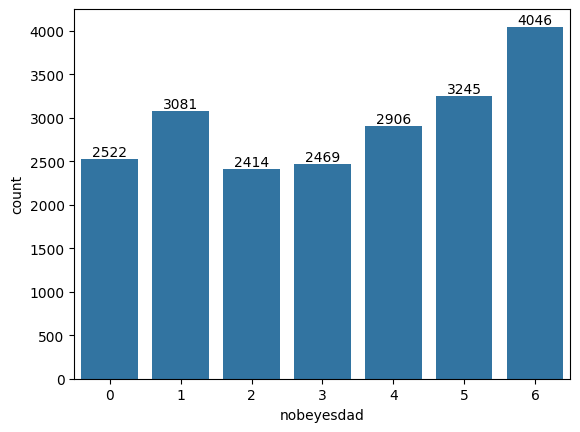

In [7]:
ax = sns.countplot(data=df, x='nobeyesdad')
for container in ax.containers:
    ax.bar_label(container)

De acuerdo al EDA, la clase 6 tenía un pico muy destacado de valores 26 en edad y valores 1.62-1.64 en altura. Antes de hacer el SMOT, vamos a intentar eliminar varios datos que reúnan estas condiciones de forma manual. Además, vamos a intentar evitar que ninguno de ellos sea un hombre (male=1), ya que a penas hay datos de hombres con obesidad de tipo 3, y no queremos sesgar aún más el df. \
Observando la gráfica podemos ver que a la clase 6 le sobran 801 valores para estar al mismo nivel que la siguiente clase más alta. Comprobemos con cuántos valores de estas características contamos.

In [23]:
print('Datos con nobeyesdad=6, age=26, height=[1.62, 1.64] y male=0:',
      len(df[(df.nobeyesdad == 6) & (df.age == 26) & (df.height >= 1.62) & (df.height <= 1.64) & (df.male == 0)]))

Datos con nobeyesdad=6, age=26, height=[1.62, 1.64] y male=0: 831


Da la casualidad de que tenemos suficientes valores que reunen las cuatro condiciones. Los eliminamos a mano mediante el método sample.

In [26]:
# Copiamos el dataframe para procesarlo
df_p = df.copy()

# Recogemos valores y eliminamos según su índice
values = df[(df.nobeyesdad == 6) & (df.age == 26) & (df.height >= 1.62) & (df.height <= 1.64) & (df.male == 0)].sample(801, random_state=42)
df_p.drop(index=values.index, inplace=True)

Veamos cómo quedan las distribuciones ahora:

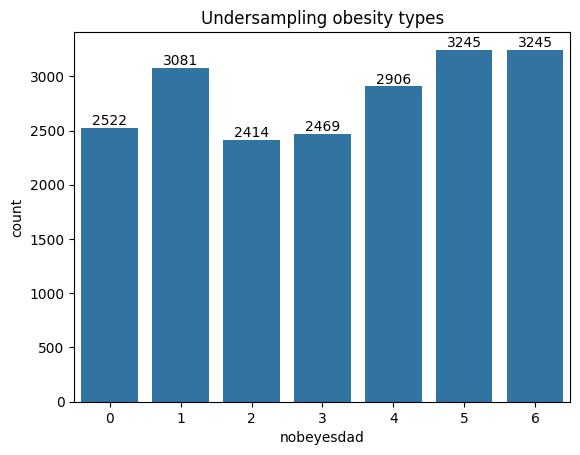

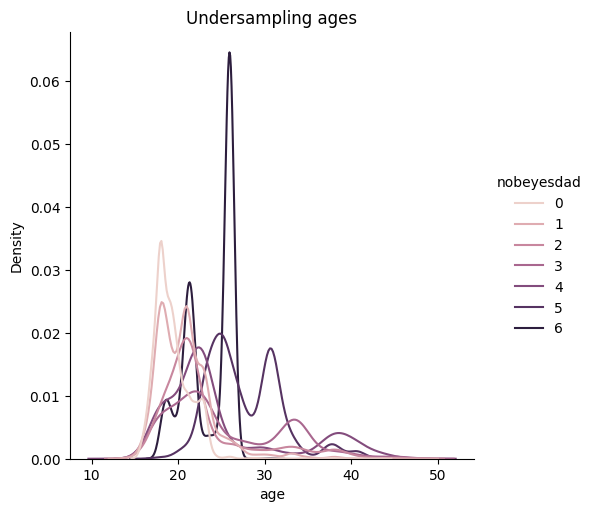

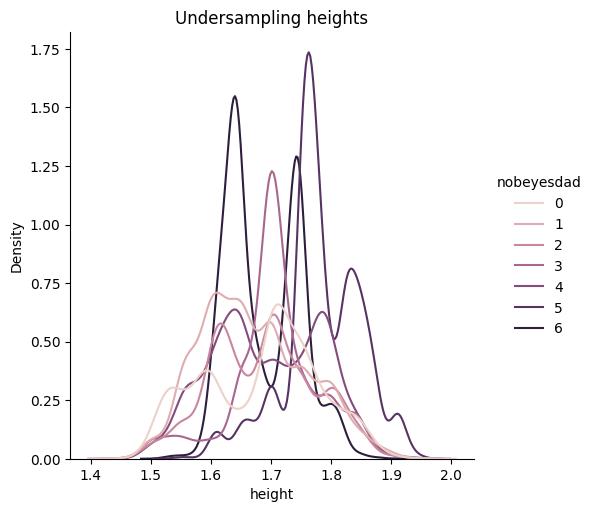

In [34]:
ax = sns.countplot(data=df_p, x='nobeyesdad')
for container in ax.containers:
    ax.bar_label(container)
ax.set(title='Undersampling obesity types')

sns.displot(data=df_p, x='age', kind='kde', hue='nobeyesdad').set(title='Undersampling ages');

# Distribución alturas según target
sns.displot(data=df_p, x='height', kind='kde', hue='nobeyesdad').set(title='Undersampling heights');

Comparados con los datos del EDA, observamos que el desequilibrio de las edades no se ha podido mitigar mucho (sigue habiendo muchísimas obesas tipo 3 cuya edad es 26), pero sí el de las alturas.

### Random Sampling

In [39]:
ros = RandomOverSampler(random_state=42)

X_ros, y_ros = ros.fit_resample(df_p.drop(columns='nobeyesdad'), df_p['nobeyesdad'])

df_s = pd.concat([X_ros, y_ros], axis=1)
df_s

,male,age,height,weight,family_history_with_overweight,favc,fcvc,ncp,caec,smoke,ch2o,scc,faf,tue,calc,mtrans_private,mtrans_public,nobeyesdad
0,1,24.443011,1.699998,81.669950,1,1,2.0,3.0,1,0,3.0,0,0.0,1.0,1,0,1,3
1,0,18.000000,1.560000,57.000000,1,1,2.0,3.0,2,0,2.0,0,1.0,1.0,0,1,0,1
2,0,18.000000,1.711460,50.165754,1,1,2.0,1.0,1,0,2.0,0,1.0,2.0,0,0,1,0
3,0,20.952737,1.710730,131.274851,1,1,3.0,3.0,1,0,2.0,0,1.0,1.0,1,0,1,6
4,1,31.641081,1.914186,93.798055,1,1,3.0,2.0,1,0,2.0,0,2.0,1.0,1,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22710,0,21.721507,1.650012,86.945380,1,1,3.0,2.0,1,0,2.0,0,1.0,0.0,0,0,1,4
22711,0,40.362129,1.534385,80.000000,1,1,2.0,3.0,1,0,2.0,0,1.0,0.0,0,1,0,4
22712,1,22.815416,1.716289,94.094184,1,1,2.0,3.0,1,0,2.0,0,0.0,2.0,0,0,1,4
22713,1,21.403421,1.716677,95.419668,1,1,2.0,3.0,1,0,3.0,0,2.0,0.0,0,0,1,4


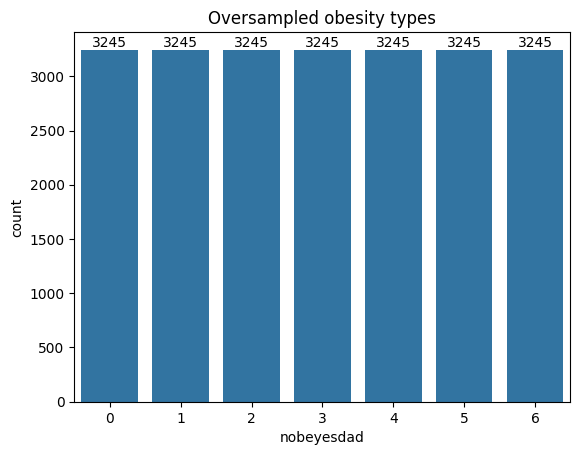

In [43]:
# Distribución target
ax = sns.countplot(data=df_s, x='nobeyesdad')
for container in ax.containers:
    ax.bar_label(container)
ax.set(title='Oversampled obesity types');

## PCA

In [45]:
# Separo la target
X = df_s.drop(columns='nobeyesdad')
y = df_s['nobeyesdad']

Reduciremos a las dimensiones necesarias como para conservar al menos el 97% de la varianza

In [72]:
pca = PCA(n_components=0.97)
X_pca_1 = pca.fit_transform(X)

print('Varianza explicada por cada dimensión:', pca.explained_variance_ratio_)
print('Varianza explicada total:', pca.explained_variance_ratio_.sum())

Varianza explicada por cada dimensión: [0.95570013 0.03935684]
Varianza explicada total: 0.9950569715122909


In [75]:
df_pca_1 = pd.concat([pd.DataFrame(X_pca_1, columns=['dim_1','dim_2']), pd.DataFrame(y)], axis=1)
df_pca_1

,dim_1,dim_2,nobeyesdad
0,-3.302424,1.125659,3
1,-28.363753,-3.580292,1
2,-35.181936,-3.226605,0
3,45.948994,-5.641451,6
4,9.266422,7.446798,3
...,...,...,...
22710,1.767519,-1.900462,4
22711,-3.928531,17.177306,4
22712,8.973713,-1.336511,4
22713,10.209108,-2.828451,4


Veamos qué aspecto tienen las clases en un gráfico:

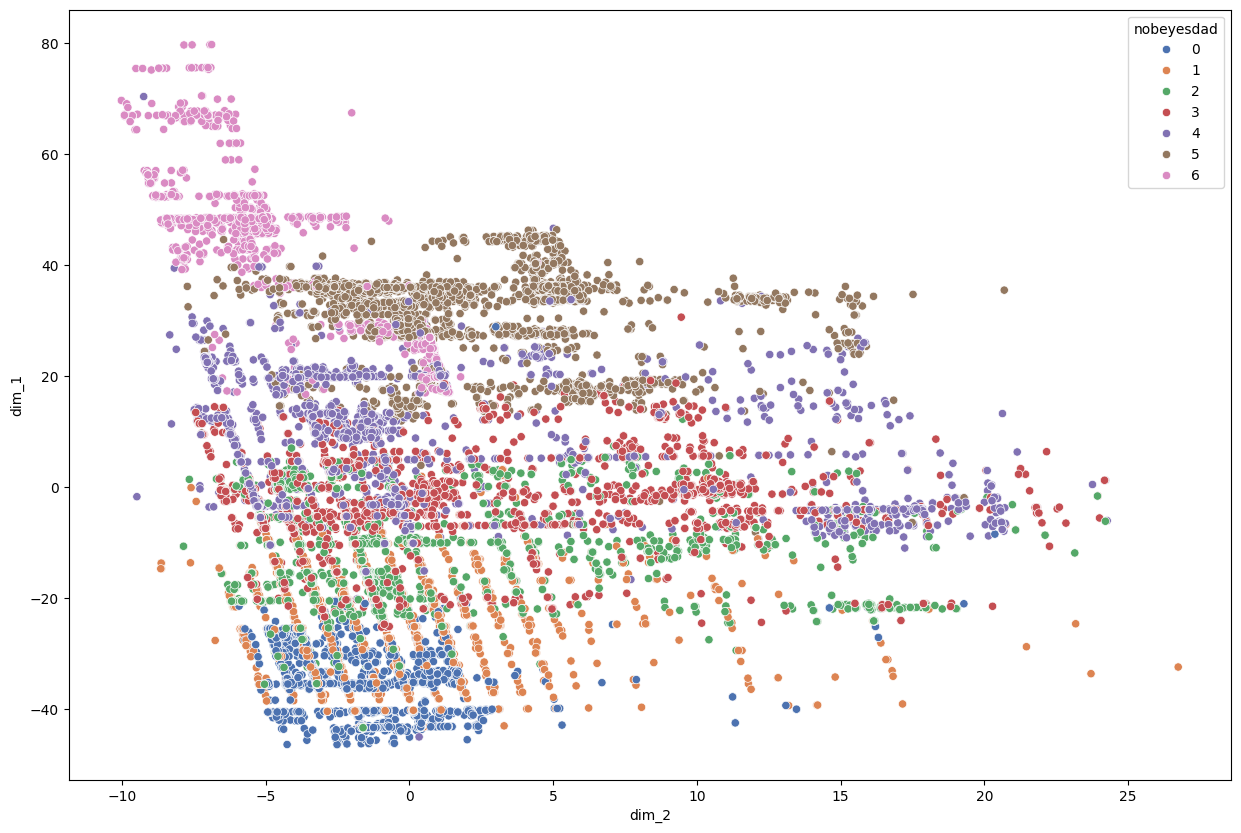

In [77]:
plt.figure(figsize=(15,10))
sns.scatterplot(data=df_pca_1,
                x='dim_2',
                y='dim_1',
                hue='nobeyesdad',
                palette='deep');

Observamos que los grupos 0, 5 y 6 están más o menos bien diferenciados, pero el resto están muy mezclados. \
Entrenamos rápidamente un modelo para ver si esta técnica nos ha sido de ayuda.

In [78]:
(cross_val_score(lgb.LGBMClassifier(), df_pca_1.drop(columns='nobeyesdad'), df_pca_1.nobeyesdad, cv=5, scoring='accuracy')).mean()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 18172, number of used features: 2
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000882 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 18172, number of used features: 2
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 18172, number of used features: 2
[LightGBM] [Info] Start training from score -1.9

Un 0.8 de accuracy es una cifra 8 puntos menor que el resultado del LGBM en la fase de baselines. \
Reducimos la dimensionalidad a 8 en vez de a 2 para ver si conseguimos un mejor resultado.

In [79]:
pca = PCA(n_components=8)
X_pca_2 = pca.fit_transform(X)

df_pca_2 = pd.concat([pd.DataFrame(X_pca_2), pd.DataFrame(y)], axis=1)

(cross_val_score(lgb.LGBMClassifier(), df_pca_2.drop(columns='nobeyesdad'), df_pca_2.nobeyesdad, cv=5, scoring='accuracy')).mean()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.038142 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 18172, number of used features: 8
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003915 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 18172, number of used features: 8
[LightGBM] [Info] Start training from score -1

0.8633502091129209

El accuracy resultante sigue siendo dos puntos inferior al 0.88 del Modelo_1 en la fase Baselines, por lo que estimo ineficiente continuar por esta vía y cancelo el Clustering para diseñar un nuevo modelo.

In [80]:
# Entrenamiento y guardado
lgbm = lgb.LGBMClassifier()
lgbm.fit(pd.DataFrame(X_pca_2), pd.DataFrame(y))

import joblib
joblib.dump(lgbm, '..\models\my_model_2.sav')

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001783 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 22715, number of used features: 8
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910
[LightGBM] [Info] Start training from score -1.945910


['..\\models\\my_model_2.sav']

<hr>

<div style="display: flex; justify-content: space-between; margin-bottom: 10px;">
    <div style="text-align: left;">
        <a href="./3_Modelo_1.ipynb">
            <button>&#8592; 3. Modelo 1 </button>
        </a>
    </div>
    <div style="text-align: right;">
        <a href="./3_Modelo_3.ipynb">
            <button>3. Modelo 3 &#8594;</button>
        </a>
    </div>
</div>

<hr>